## WiFi Data Exploration, bot cleaning

## NOTE: Cells referencing or visualizing dataframe rows have been removed to protect confidentiality of client devices and their addresses

To the extent that this can be written in a reproducible fashion, it is. However, due to the nature of the data, which cannot be publicized, this code downloaded as-is will not run.

In [2]:
import csv
import urllib2
import matplotlib.pylab as plt
%pylab inline
import numpy as np
import pandas as pd
from scipy.stats import norm
from pandas import Series, DataFrame,Panel

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
import datetime as dt

In [3]:
real_df = pd.read_csv('sample_day.csv')

df = real_df

In [4]:
#dataframes of clients who are and are not associated with a network they ping
dff = (df.loc[df['is_associated'] == False])
dft = (df.loc[df['is_associated'] == True])

In [10]:
df['last_seen_dt'] = pd.to_datetime(df['last_seen'].apply(lambda s: s.split(".")[0] + " 2017"),
                                    format="%a %b %d %H:%M:%S %Y")


## Determine which client addresses are universal vs local

In [5]:
def is_universal(mac_addr):
    """ Given a MAC address, returns boolean regarding whether the second-least significant digit in first octet is 0"""
    return mac_addr[1] in '014589cd'

In [6]:
df['is_uni'] = df['client_mac'].apply(is_universal)

In [14]:
second_to_last_digits = {}
for addr in df['client_mac']:
    k = addr[1]
    second_to_last_digits[k] = second_to_last_digits.get(k, 0) + 1
    
print(second_to_last_digits)

{'8': 613154, 'c': 812044, '4': 645958, '0': 899549}


In [15]:
# Focusing on universal MAC addresses only
universal_macs = (df.loc[df['is_uni'] == True])

In [16]:
universal_macs.head(5)
print universal_macs.shape
print df.shape

#All MACs are universal

(2970705, 7)
(2970705, 7)


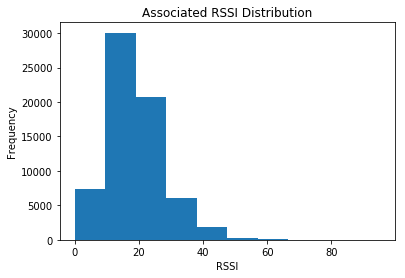

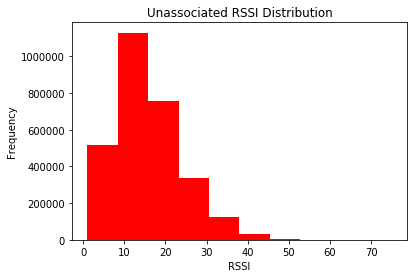

In [17]:
#Plot of Connected RSSI Values

plt.hist(dft['rssi'])
plt.title('Associated RSSI Distribution')
plt.xlabel('RSSI')
plt.ylabel('Frequency')
plt.show()

plt.hist(dff['rssi'], color='red')
plt.title('Unassociated RSSI Distribution')
plt.xlabel('RSSI')
plt.ylabel('Frequency')
plt.show()

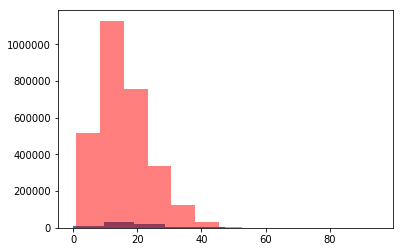

In [18]:
#Plot them together
plt.hist(dft['rssi'])
plt.hist(dff['rssi'], color='red', alpha=0.5)
plt.show()

In [19]:
total_pings = (len(dft.index) + len(dff.index))
assc_pings = len(dft.index)
unassc_pings = len(dff.index)
print('Total pings today: %s' % total_pings)
print('Number of associated pings today: %s' % assc_pings)
print('Number of unassociated pings today: %s' % unassc_pings)
print('Associated pings make up %s percent of the total pings' % ((assc_pings/total_pings)*100))

assc_mean = np.mean(dft['rssi'])
unassc_mean = np.mean(dff['rssi'])
print('Average associated RSSI: %s' % assc_mean)
print('Average unassociated RSSI: %s' % unassc_mean)




Total pings today: 2970705
Number of associated pings today: 66399
Number of unassociated pings today: 2904306
Associated pings make up 0 percent of the total pings
Average associated RSSI: 18.6252353198
Average unassociated RSSI: 15.8741155374


In [7]:
groups = df.groupby([df['client_mac'], df['ap_mac']]).size()
#will display all the APs sorted by which client accessed them, and the number of times the AP was accessed by the client

## Exploring vendor representation in the data

In [24]:
bots = (grouped.loc[grouped['ap_mac'] == 1])
bots.head(5)
bots.shape
bots['vendor_bit'] = bots['client_mac'].str[:8]
bots.head(5)
bot_vendors = bots['vendor_bit'].nunique()
print(bot_vendors)

1963


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
#The following removes all client mac addresses that only ever accessed one unique AP during the day.. and we lose about
# 80k clients this way.

tossed_bots = (grouped.loc[grouped['ap_mac'] > 1])
tossed_bots.shape

(150769, 2)

In [28]:
individual_vendors = tossed_bots['vendor_bit'].nunique()
print(individual_vendors)

2095


In [31]:
def identify_vendor(mac_addr):
    api_url = "http://api.macvendors.com/%s" % mac_addr
    f = urllib2.urlopen(api_url)
    response = f.read()
    return response

In [36]:
# Test it
identify_vendor(vendor_list[0])

'Apple, Inc.'

In [37]:
vendors = []
for mac_addr in vendor_list:
    try:
        vendor = identify_vendor(mac_addr)
    except:
        vendor = None
        
    vendors.append(vendor)

In [34]:
vendors[:10]

['Apple, Inc.',
 'Intel Corporate',
 'Samsung Electronics Co.,Ltd',
 'Apple, Inc.',
 'Murata Manufacturing Co., Ltd.',
 'Apple, Inc.',
 'Murata Manufacturing Co., Ltd.',
 'Nokia Corporation',
 'Samsung Electronics Co.,Ltd',
 'Xiaomi Communications Co Ltd']

In [35]:
vendor_mapping = dict(zip(vendor_list, vendors))
vendor_mapping[vendor_list[0]]

'Apple, Inc.'

In [ ]:
client_mac = df['client_mac'][0]
print(client_mac)
print(vendor_list[0])

def lookup_vendor(mac_addr):
    first_three_chunks = ":".join(mac_addr.split(":")[:3])
    return vendor_mapping.get(first_three_chunks, None)

lookup_vendor(client_mac)
client_vendors = [lookup_vendor(client_mac) for client_mac in df['client_mac']]
df['client_vendor'] = client_vendors

In [41]:
filtered = df.dropna(how='any')

In [42]:
df.shape[0] - filtered.shape[0]
###THERE ARE 18,422 unidentified macs (vendors)

18747

## Experiment with vendors by count and representation

In [44]:
all_vendors = filtered['client_vendor'].value_counts().index.tolist()
top_vendors = all_vendors[:30]
samsung = ['SAMSUNG ELECTRO-MECHANICS(THAILAND)', 'Samsung Electronics Co.,Ltd', 'SAMSUNG ELECTRO MECHANICS CO., LTD.']
huawei = ['HUAWEI TECHNOLOGIES CO.,LTD']
oneplus = ['OnePlus Tech (Shenzhen) Ltd']

In [141]:
top_vendors

['Apple, Inc.',
 'Intel Corporate',
 'SAMSUNG ELECTRO-MECHANICS(THAILAND)',
 'Samsung Electronics Co.,Ltd',
 'Murata Manufacturing Co., Ltd.',
 'LG Electronics (Mobile Communications)',
 'Motorola Mobility LLC, a Lenovo Company',
 'HTC Corporation',
 'HUAWEI TECHNOLOGIES CO.,LTD',
 'zte corporation',
 'Ruckus Wireless',
 'Hon Hai Precision Ind. Co.,Ltd.',
 'Liteon Technology Corporation',
 'OnePlus Tech (Shenzhen) Ltd',
 'Aerohive Networks Inc.',
 'AzureWave Technology Inc.',
 'Hewlett Packard',
 'Sony Mobile Communications AB',
 'SAMSUNG ELECTRO MECHANICS CO., LTD.',
 'Zebra Technologies Inc',
 'TCT mobile ltd',
 'Amazon Technologies Inc.',
 'ASUSTek COMPUTER INC.',
 'COMPEX INCORPORATED',
 'Wistron Neweb Corporation',
 'Xiaomi Communications Co Ltd',
 'Google, Inc.',
 'Microsoft Mobile Oy',
 'Chicony Electronics Co., Ltd.',
 'Microsoft']

In [ ]:
#select for useful vendors test with Apple
filtered_apple =  filtered[filtered['client_vendor'].isin(['Apple, Inc.'])]
filtered_apple.head()

In [46]:
#select for useful vendors
filtered_vendors =  filtered[filtered['client_vendor'].isin(top_vendors)]
print filtered_vendors.shape

(2764443, 8)


In [48]:
filtered_group = df.groupby([df['client_vendor'], df['client_mac']]).size()

In [49]:
def make_key(dtime):
    return "%02d:%02d" % (dtime.hour, dtime.minute - (dtime.minute % 10))

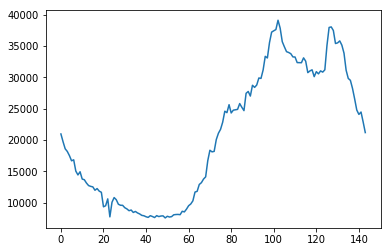

In [52]:
def show_daily_pings(df):
    time_freqs = {}
    for dtime in df['last_seen_dt']:
        key = make_key(dtime)
        time_freqs[key] = time_freqs.get(key, 0) + 1
    
    xs, ys = zip(*sorted(time_freqs.items()))

    plt.plot(ys)
    plt.show()
    
show_daily_pings(df)

## Shift datetime in dataframe to represent EST

In [58]:
shifted_date = [date - datetime.timedelta(hours = 4) for date in df['last_seen_dt']]

In [59]:
filtered_apple['shifted_date'] = [date - datetime.timedelta(hours = 4) for date in filtered_apple['last_seen_dt']]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [60]:
filtered_vendors['shifted_date'] = [date - datetime.timedelta(hours = 4) for date in filtered_vendors['last_seen_dt']]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


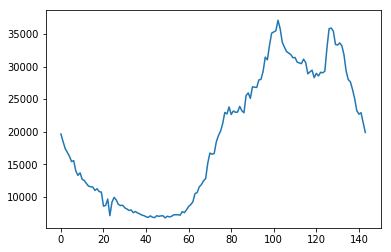

In [61]:
show_daily_pings(filtered_vendors)

In [62]:
def show_daily_pings(df):
    time_freqs = {}
    for dtime in df['shifted_date']:
        key = make_key(dtime)
        time_freqs[key] = time_freqs.get(key, 0) + 1
    
    xs, ys = zip(*sorted(time_freqs.items()))

    plt.plot(ys)
    plt.show()

In [63]:
df['shifted_date'] = [date - datetime.timedelta(hours = 4) for date in df['last_seen_dt']]

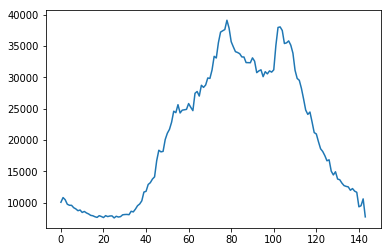

In [64]:
show_daily_pings(df)

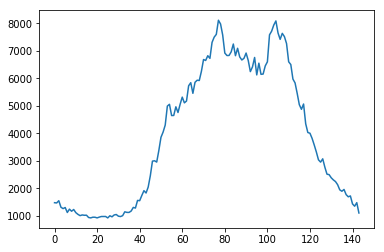

In [65]:
show_daily_pings(filtered_apple)

In [66]:
filtered_samsung =  filtered[filtered['client_vendor'].isin(samsung)]

In [67]:
filtered_samsung['shifted_date'] = [date - datetime.timedelta(hours = 4) for date in filtered_samsung['last_seen_dt']]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


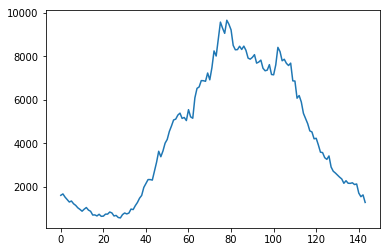

In [68]:
show_daily_pings(filtered_samsung)


In [69]:
filtered_huawei = filtered[filtered['client_vendor'].isin(huawei)]

In [70]:
filtered_huawei['shifted_date'] = [date - datetime.timedelta(hours = 4) for date in filtered_huawei['last_seen_dt']]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


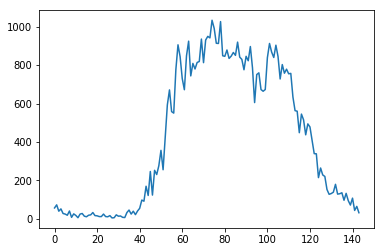

In [71]:
show_daily_pings(filtered_huawei)

In [144]:
filtered_oneplus = filtered[filtered['client_vendor'].isin(oneplus)]
filtered_oneplus['shifted_date'] = [date - datetime.timedelta(hours = 4) for date in filtered_oneplus['last_seen_dt']]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


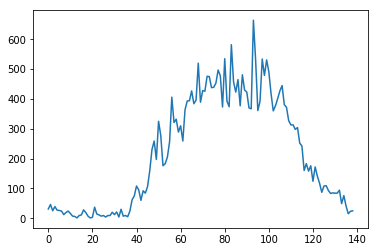

In [145]:
show_daily_pings(filtered_oneplus)
#Chinese smartphones

In [147]:
print filtered_oneplus.shape
print filtered_huawei.shape
print filtered_apple.shape
print filtered_samsung.shape

(30407, 9)
(60148, 9)
(563345, 9)
(620998, 9)


## Bot detection and extraction

In [80]:
client_macs = list(df['client_mac'])
ap_macs = list(df['ap_mac'])
ping_times = list(df['last_seen_dt'])

tuples = [((client_macs[i], ap_macs[i]), ping_times[i]) for i in range(len(client_macs))]
tuples.sort(key = lambda (val, t): t)

In [57]:
shortest_reping = datetime.timedelta(days = 1)

observances = {}
for (client_ap_pair, ping_time) in tuples:
    if client_ap_pair not in observances: 
        observances[client_ap_pair] = [ping_time]
    else:
        observances[client_ap_pair].append(ping_time)
        reping_time = observances[client_ap_pair][-1] - observances[client_ap_pair][-2]
        shortest_reping = min(shortest_reping, reping_time)

print(shortest_reping)

0 days 00:00:00


In [ ]:
print(shortest_reping.total_seconds())
len(observances)
sample_keys = observances.keys()[:10]
for key in sample_keys:
    print key, ": ", observances[key]

## Bot detection mechanism-- setting frequency of pings in time window to mean nonhuman activity

In [74]:
class IRollingWindowCounts(object):
    # Don't actually instantiate this class. Use RollingWindowCounts below.
    def __init__(self, tdelta):
        """
        Initializes the object with some duration of time
        For example, a 30 second window. tdelta is a timedelta object.
        """
        raise NotImplementedError("To be implemented by subclass.")

    def insert(self, t, val):
        """
        Insert a value val that occured at time t (a datetime).
        Maybe you want to keep track of mac addresses.
        """
        raise NotImplementedError("To be implemented by subclass.")

    def count(self, val):
        """
        Count the number of times this val has been seen
        in the last tdelta amount of time.
        """
        raise NotImplementedError("To be implemented by subclass.")

In [75]:
"""
For example, if you have a list of (client_mac, ping_time) tuples, you
could detect bots with this code:
"""
import datetime
def detect_bots(ping_tuples):
    bots = {}
    rolling_window = RollingWindowCounts(datetime.timedelta(seconds=60))
    for (val, ping_time) in ping_tuples:
        rolling_window.insert(ping_time, val)
        if rolling_window.count(val) >= 2:
            bots[val] = True

    return bots.keys()
        

In [76]:
##### Implementation of the class #####
from collections import deque
class RollingWindowCounts(IRollingWindowCounts):
    """
    A class that keeps track of the number of times objects have been
    inserted into it in the past fixed amount of time. Inserts must be
    in increasing time order.
    """
    def __init__(self, tdelta):
        self._tdelta = tdelta
        self._counts = {} # val --> frequency
        self._inserts = deque() # A deque of (t, val) tuples

    def count(self, val):
        return self._counts.get(val, 0)
    
    def insert(self, t, val):
        self._inserts.append((t, val))
        self._counts[val] = self._counts.get(val, 0) + 1

        # Remove old items
        old_t, old_val = self._pop_oldest()      
        while t - old_t > self._tdelta:
            old_t, old_val = self._pop_oldest()

        self._inserts.appendleft((old_t, old_val))
        self._counts[old_val] = self._counts.get(old_val, 0) + 1

    def _pop_oldest(self):
        """ Pops oldest (t, val) and updates _counts. """
        old_t, old_val = self._inserts.popleft()
        self._counts[old_val] -= 1
        if self._counts[old_val] == 0:
            del self._counts[old_val]

        return (old_t, old_val)

In [82]:
bot_attempt = detect_bots(tuples)

In [83]:
bot_60_10 = bot_attempt

In [ ]:
new_df_test = df[~df.client_mac.isin(bot_60_10)]
new_df_test2 = df[~df.client_mac.isin(bot_df_test)]

In [ ]:
bot_df_test = [ seq[0] for seq in tmp_60_2 ]

In [87]:
new_df_test2['shifted_date'] = [date - datetime.timedelta(hours = 4) for date in new_df_test2['last_seen_dt']]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Plot of frequencies of non-bot clients (top) and bot clients (bottom)

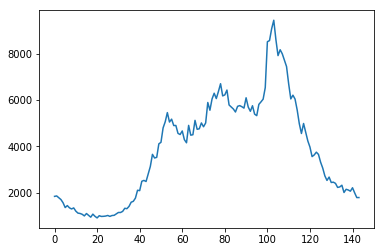

In [91]:
show_daily_pings(new_df_test2)

In [92]:
new_df_test2_bot = df[df.client_mac.isin(bot_df_test)]

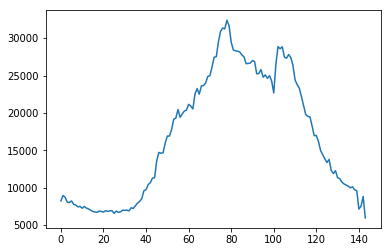

In [94]:
show_daily_pings(new_df_test2_bot)